In [103]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
from torchvision.transforms import transforms

from imagedataset import ImageDataset

In [104]:
torch.cuda.is_available()

True

In [105]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Hyperparameters

In [106]:
version = 3
num_epochs = 5
batch_size = 10
learning_rate = 0.001
artifact_name = "model_dropout"

### Data

In [107]:
norm_transform = transforms.Normalize(
    (132.3501, 127.2977, 131.0638),
    (55.5031, 62.3274, 64.1869)
)

In [108]:
dataset = ImageDataset()
train_size = int(0.75*len(dataset))
test_size  = len(dataset) - train_size
train, test = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader  = DataLoader(test, batch_size=batch_size, shuffle=False)

### Model, loss & optimizer

In [109]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 25 * 25, 512)
        self.dropout1 = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(512, 29)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 25 * 25)
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

In [110]:
model = ConvNet().to(device)
if version != 1:
    model.load_state_dict(torch.load("./model_states/"+artifact_name+"_v"+str(version-1)+".pth"))
criterion = nn.CrossEntropyLoss() # Includes softmax
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### Training loop

In [111]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.float().to(device)
        labels = labels.to(device)

        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 500 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}")

Epoch [1/5], Step [500/6525], Loss: 0.0107
Epoch [1/5], Step [1000/6525], Loss: 0.0502
Epoch [1/5], Step [1500/6525], Loss: 0.0042
Epoch [1/5], Step [2000/6525], Loss: 0.0002
Epoch [1/5], Step [2500/6525], Loss: 0.0034
Epoch [1/5], Step [3000/6525], Loss: 0.0003
Epoch [1/5], Step [3500/6525], Loss: 0.0043
Epoch [1/5], Step [4000/6525], Loss: 0.0142
Epoch [1/5], Step [4500/6525], Loss: 0.0003
Epoch [1/5], Step [5000/6525], Loss: 0.0160
Epoch [1/5], Step [5500/6525], Loss: 0.0000
Epoch [1/5], Step [6000/6525], Loss: 0.0003
Epoch [1/5], Step [6500/6525], Loss: 0.0003
Epoch [2/5], Step [500/6525], Loss: 0.0010
Epoch [2/5], Step [1000/6525], Loss: 0.0003
Epoch [2/5], Step [1500/6525], Loss: 0.0001
Epoch [2/5], Step [2000/6525], Loss: 0.0004
Epoch [2/5], Step [2500/6525], Loss: 0.0001
Epoch [2/5], Step [3000/6525], Loss: 0.0001
Epoch [2/5], Step [3500/6525], Loss: 0.0000
Epoch [2/5], Step [4000/6525], Loss: 0.0000
Epoch [2/5], Step [4500/6525], Loss: 0.0197
Epoch [2/5], Step [5000/6525], Los

### Validation

In [138]:
with torch.no_grad(): 

    labs = np.empty(0, dtype=object) # List for all labels and predictions in test set
    pred = np.empty(0, dtype=object)
    for (images, labels) in test_loader:
        images = images.float().to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1) # Retrieving index of maximum output
        labs = np.append(labs, labels.detach().cpu().numpy())
        pred = np.append(pred, predicted.detach().cpu().numpy())

3
5
3
1
2
8
0
0
3
1
5
6
1
7
0
6
2
8
7
0
7
1
4
1
0
3
0
3
3
5
6
8
2
8
9
2
7
2
9
1
5
3
2
3
5
1
3
7
2
3
4
1
6
1
0
2
5
0
8
1
6
1
0
5
5
2
6
7
8
5
2
1
9
4
1
1
0
4
9
1
8
6
3
8
5
5
8
8
6
2
7
2
0
6
1
5
4
4
0
7
1
2
5
9
5
7
1
4
7
0
1
4
7
9
1
5
0
9
2
3
3
0
1
4
1
5
0
7
5
6
3
6
0
0
2
5
2
0
3
9
2
7
5
1
9
5
5
7
7
1
2
6
2
7
8
5
1
3
8
9
3
6
4
5
5
5
0
2
7
4
0
5
5
3
0
0
9
8
0
0
1
1
6
8
0
6
4
0
8
0
1
1
4
6
8
6
3
7
1
3
4
7
6
1
9
7
0
3
0
4
4
1
1
1
1
2
5
2
7
1
7
2
2
3
5
6
3
0
9
2
5
1
2
0
4
1
3
1
0
7
0
4
1
9
5
8
4
4
7
2
8
3
5
9
3
2
2
5
4
1
5
9
1
4
9
5
4
6
8
5
5
5
2
3
3
9
1
1
2
5
4
4
9
9
8
5
2
5
8
8
1
2
8
1
5
4
7
8
5
7
5
5
1
8
1
2
4
2
3
1
3
8
8
0
9
0
5
3
3
1
5
4
4
4
3
2
1
1
6
7
0
1
2
5
2
2
2
2
9
7
6
9
3
3
5
5
8
9
5
1
8
1
9
5
2
8
8
9
2
3
8
0
9
6
5
0
2
5
7
4
9
8
1
9
8
0
9
3
4
3
3
8
5
7
4
2
5
3
0
8
1
3
1
9
1
0
0
8
0
0
2
2
1
2
0
3
2
4
5
0
4
8
8
3
1
4
2
0
1
1
2
4
7
7
8
3
1
1
6
4
8
3
0
0
6
5
2
3
3
0


KeyboardInterrupt: 

In [113]:
# Total accuracy
accuracy = np.round((labs == pred).mean(), 3)

# In-class accuracy:
num_classes = 29
class_accuracy = np.zeros(num_classes)
for i in range(num_classes):
    class_ind = (labs == i) # Indices of class i in labs and pred
    class_accuracy[i] = np.mean(labs[class_ind] == pred[class_ind])

print(f"Accuracy: {accuracy}")

Accuracy: 0.999


C:\Users\David\AppData\Local\Temp\ipykernel_26912\1326323193.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn");


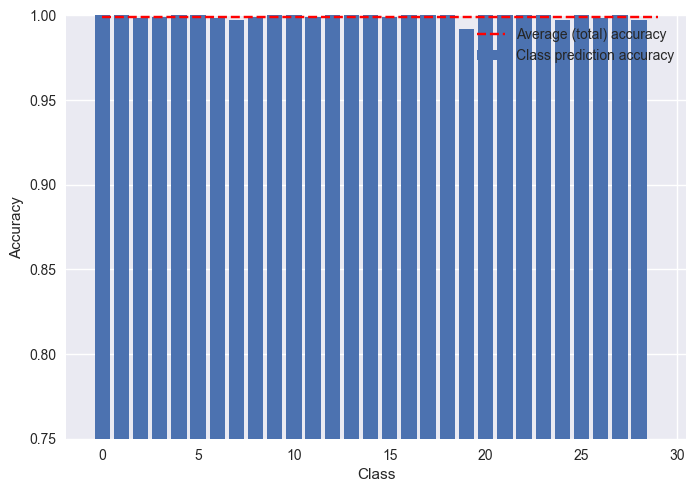

In [114]:
plt.style.use("seaborn");
plt.ylim([0.75, 1])
plt.bar(range(num_classes), class_accuracy, label="Class prediction accuracy")
plt.hlines(accuracy, 0, num_classes, colors="red", linestyles="--", label="Average (total) accuracy")
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.legend()

In [115]:
torch.save(model.state_dict(), f="./model_states/"+artifact_name+"_v"+str(version)+".pth")